In [73]:
import math
import os
import time
import wget
import random
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, rnn
from mxnet.gluon.data import ArrayDataset, DataLoader
import string
import tarfile
import urllib
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
import cv2
import numpy as np
import _pickle as cPickle
import re
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import pickle
from leven import levenshtein
import glob
import matplotlib.gridspec as gridspec
%matplotlib inline

# Hand-writing detection using CNN + biLSTM + CTC-loss

In [2]:
DESIRED_SIZE = (32,128)
IMAGES_DATA_FILE = 'images_data.pkl'
DATA_FOLDER = 'handwritting'
USERNAME = 'thomasdelteil'
PASSWORD = 'delteilthomas'

## Data Preprocessing

In [3]:
def pre_processing(img_in):    
    im = cv2.imread(img_in, cv2.IMREAD_GRAYSCALE)
    size = im.shape[:2] # old_size is in (height, width) format
    if size[0] > DESIRED_SIZE[0] or size[1] > DESIRED_SIZE[1]:
        ratio_w = float(DESIRED_SIZE[0])/size[0]
        ratio_h = float(DESIRED_SIZE[1])/size[1]
        ratio = min(ratio_w, ratio_h)
        new_size = tuple([int(x*ratio) for x in size])
        im = cv2.resize(im, (new_size[1], new_size[0]))
        size = im.shape

    delta_w = max(0, DESIRED_SIZE[1] - size[1])
    delta_h = max(0, DESIRED_SIZE[0] - size[0])
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    color = im[0][0]
    if color < 230:
        color = 230
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(color))
    img_arr = np.asarray(new_im)
    return img_arr

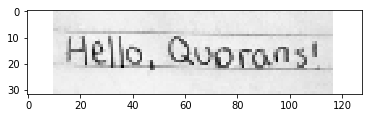

In [4]:
plt.imshow(pre_processing('handwriting.png'), cmap='Greys_r')

## Data Download

If the data is already pickled, we don't bother downloading and loading. We read directly from disk

In [5]:
if os.path.isfile(IMAGES_DATA_FILE):
    images_data = pickle.load(open(IMAGES_DATA_FILE, 'rb'))
else:
    images_data = None

In [6]:
if images_data is None:
    password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()

    url_partial = "http://www.fki.inf.unibe.ch/DBs/iamDB/data/"
    urls = ['{}words/words.tgz'.format(url_partial), '{}xml/xml.tgz'.format(url_partial)]

    if not os.path.isdir(DATA_FOLDER):
        os.makedirs(DATA_FOLDER)

    for url in urls:
        password_mgr.add_password(None, url, USERNAME, PASSWORD)
        handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
        opener = urllib.request.build_opener(handler)
        urllib.request.install_opener(opener)
        archive_file = os.path.join(DATA_FOLDER, url.split('/')[-1])
        if not os.path.isfile(archive_file):
            opener.open(url)    
            urllib.request.urlretrieve(url, filename=os.path.join(DATA_FOLDER, url.split('/')[-1]))[0]
            tar = tarfile.open(archive_file, "r:gz")
            tar.extractall(os.path.join(model_folder,'extract'))
            tar.close()

## Data Loading

In [7]:
%%time
if images_data is None:
    error_count = 0
    images_data = dict()
    image_files = glob.glob(DATA_FOLDER + '/**/*.png', recursive=True)
    for filepath in image_files:
        try:
            processed_img = pre_processing(filepath)                
            images_data[filepath.split('/')[-1].split('.')[0]] = [processed_img]
        except:
            error_count += 1


    xml_files = glob.glob(DATA_FOLDER + '/**/*.xml', recursive=True)
    for filepath in xml_files:
        tree = ET.parse(filepath)
        root = tree.getroot()
        for word in root.iter('word'):
            if word.attrib['id'] in images_data:
                images_data[word.attrib['id']].append(word.attrib['text'])

    print("{} images successfully loaded, {} errors".format(len(images_data), error_count))
    images_data = [(images_data[key][0], images_data[key][1]) for key in images_data]
    pickle.dump(images_data, open(IMAGES_DATA_FILE, 'wb'))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs


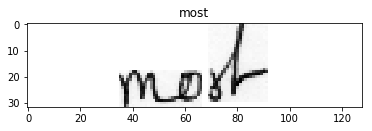

In [8]:
for i in range(10):
    n = int(random.random()*len(images_data))
    ax = plt.imshow(images_data[n][0], cmap='Greys_r')
    plt.title(images_data[n][1])
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)

## Data Set creation

In [23]:
SEQ_LEN = 32
ALPHABET = string.ascii_letters+string.digits+string.punctuation+' '
ALPHABET_INDEX = {ALPHABET[i]:i for i in range(len(ALPHABET))}
ALPHABET_SIZE = len(ALPHABET)+1
BATCH_SIZE = 64
print(ALPHABET)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [24]:
random.shuffle(images_data)
split = 0.8
images_data_train = images_data[:int(split*len(images_data))]
images_data_test = images_data[int(split*len(images_data)):]

In [25]:
def transform(image, label):
    image = np.expand_dims(image, axis=0).astype(np.float32)/255.
    label_encoded = np.zeros(SEQ_LEN, dtype=np.float32)-1
    for i, letter in enumerate(label):
        if i >= SEQ_LEN:
            break
        label_encoded[i] = ALPHABET_INDEX[letter]
    
    return image, label_encoded

In [26]:
dataset_train = ArrayDataset(images_data_train).transform(transform)
dataset_test = ArrayDataset(images_data_test).transform(transform)

In [27]:
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, last_batch='discard', shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, last_batch='discard', shuffle=True)

## Model Creation

In [51]:
NUM_HIDDEN = 200
NUM_CLASSES = 13550
NUM_LSTM_LAYER = 1
p_dropout = 0.5

Compute context

In [29]:
ctx = mx.gpu()

### Featurizer layer
We use a CNN to featurize the input data

In [30]:
featurizer = gluon.nn.HybridSequential()
with featurizer.name_scope():
    # conv layer
    featurizer.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
#    featurizer.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
    featurizer.add(gluon.nn.BatchNorm())
#    featurizer.add(gluon.nn.Dropout(p_dropout))
    
    # second conv layer
    featurizer.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
    featurizer.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
#    featurizer.add(gluon.nn.BatchNorm())
#    featurizer.add(gluon.nn.Dropout(p_dropout))
    
    #third conv layer
    featurizer.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
#    featurizer.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
    featurizer.add(gluon.nn.BatchNorm())
    featurizer.add(gluon.nn.Dropout(p_dropout))
    
    #fourth layer
    featurizer.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
    featurizer.add(gluon.nn.BatchNorm())
#   featurizer.add(gluon.nn.Dropout(p_dropout))
featurizer.hybridize()

### Encoder layer
The LSTM will take the data in temporal order (left to right), SEQ_LEN slices and will encoded them

We define a custom layer that is going to:
- reshape the data from (N, W, H) to (SEQ_LEN, N, CHANNELS)
- run the biDirectional LSTM
- reshape the data from (SEQ_LEN, N, HIDDEN_UNITS) to (N, SEQ_LEN, HIDDEN_UNITS)

In [31]:
class EncoderLayer(gluon.Block):
    def __init__(self, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        with self.name_scope():
            self.lstm = mx.gluon.rnn.LSTM(NUM_HIDDEN, NUM_LSTM_LAYER, bidirectional=True)
    def forward(self, x):
        x = x.transpose((0,3,1,2))
        x = x.flatten()
        x = x.split(num_outputs=SEQ_LEN, axis = 1) # (SEQ_LEN, N, CHANNELS)
        x = nd.concat(*[elem.expand_dims(axis=0) for elem in x], dim=0)
        x = self.lstm(x)
        x = x.transpose((1, 0, 2)) # (N, SEQ_LEN, HIDDEN_UNITS)
        return x

In [32]:
encoder = gluon.nn.Sequential()
with encoder.name_scope():
    encoder.add(EncoderLayer())
    encoder.add(gluon.nn.Dropout(p_dropout))

### Decoder layer
The resulting encoded slices will be fed to a fully connected layer of size ALPHABET_SIZE and the result will be fed to a CTC loss

In [33]:
decoder = mx.gluon.nn.Dense(units=ALPHABET_SIZE, flatten=False)
decoder.hybridize()

### Loss

In [34]:
ctc_loss = gluon.loss.CTCLoss()

### Net Assembly

In [35]:
net = gluon.nn.Sequential()
net.add(featurizer)
net.add(encoder)
net.add(decoder)

### Parameters initialization

In [36]:
featurizer.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
encoder.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
decoder.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

### Trainer

In [52]:
LEARNING_RATE = 0.0001
trainer_featurizer = gluon.Trainer(featurizer.collect_params(), 'adam', {'learning_rate': LEARNING_RATE, })
trainer_encoder = gluon.Trainer(encoder.collect_params(), 'adam', {'learning_rate': LEARNING_RATE, })
trainer_decoder = gluon.Trainer(decoder.collect_params(), 'adam', {'learning_rate': LEARNING_RATE, })

### Evaluation loop

In [47]:
# This decodes the predictions and the labels back to words
def decode(prediction):
    results = []
    for word in prediction:
        result = []
        for i, index in enumerate(word):
            if i < len(word) - 1 and word[i] == word[i+1] and word[-1] != -1: #Hack to decode label as well
                continue
            if index == len(ALPHABET) or index == -1:
                continue
            else:
                result.append(ALPHABET[int(index)])
        results.append(result)
    words = [''.join(word) for word in results]
    return words

We use a metric based on the levenshtein distance. This measure what is the number of operations we would need to apply to the prediction in % of the total length of the label

In [48]:
def metric_levenshtein(predictions, labels):
    predictions = predictions.softmax().topk(axis=2).asnumpy()
    zipped = zip(decode(labels.asnumpy()), decode(predictions))
    metric = sum([(len(label)-levenshtein(label, pred))/len(label) for label, pred in zipped])
    return metric/len(labels)

In [49]:
def evaluate_accuracy(net, dataloader):
    metric = 0
    for i, (data, label) in enumerate(dataloader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        metric += metric_levenshtein(output, label)
    return metric/(i+1)

In [27]:
%%time
evaluate_accuracy(net, dataloader_test)

CPU times: user 9.4 s, sys: 1.77 s, total: 11.2 s
Wall time: 10.5 s


-1.428096203609327

### Training loop

In [115]:
epochs = 1
print_n = 350
for e in range(epochs):    
    loss = nd.zeros(1, ctx)
    tick = time.time()
    acc = nd.zeros(1, ctx)
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)

        with autograd.record():
            output = net(data)
            loss_ctc = ctc_loss(output, label)
        loss_ctc.backward()
        loss += loss_ctc.mean()
        trainer_featurizer.step(data.shape[0])
        trainer_encoder.step(data.shape[0])
        trainer_decoder.step(data.shape[0])
            
        if i%print_n == 0 and i > 0:
            print('Batches {0}: CTC Loss: {1:.2f}, time:{2:.2f} s'.format(
                i, float(loss.asscalar()/print_n), time.time()-tick))
            loss = nd.zeros(1, ctx)
            tick = time.time()
            nd.waitall()
    validation_accuracy = evaluate_accuracy(net, dataloader_test)
    print("Epoch {0}, Val_acc {1:.2f}".format(e, validation_accuracy))

Batches 350: CTC Loss: 2.60, time:14.73 s
Batches 700: CTC Loss: 2.55, time:14.96 s
Batches 1050: CTC Loss: 2.60, time:14.91 s
Batches 1400: CTC Loss: 2.54, time:14.72 s
Epoch 0, Val_acc 0.85


## Evaluation

In [ ]:
def plot_predictions(images, predictions, labels):
    gs = gridspec.GridSpec(6, 3)
    fig = plt.figure(figsize=(15, 10))
    gs.update(hspace=0.1, wspace=0.1)
    for gg, prediction, label, image in zip(gs, predictions, labels, images):
        gg2 = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gg)
        ax = fig.add_subplot(gg2[:,:])
        ax.imshow(image.asnumpy().squeeze(), cmap='Greys_r')
        ax.tick_params(axis='both',       
                       which='both',      
                       bottom='off',      
                       top='off',         
                       left='off',
                       right='off',
                       labelleft='off',
                       labelbottom='off') 
        ax.axes.set_title("{} | {}".format(label, prediction))

In [158]:
for i, (data, label) in enumerate(dataloader_test):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    break

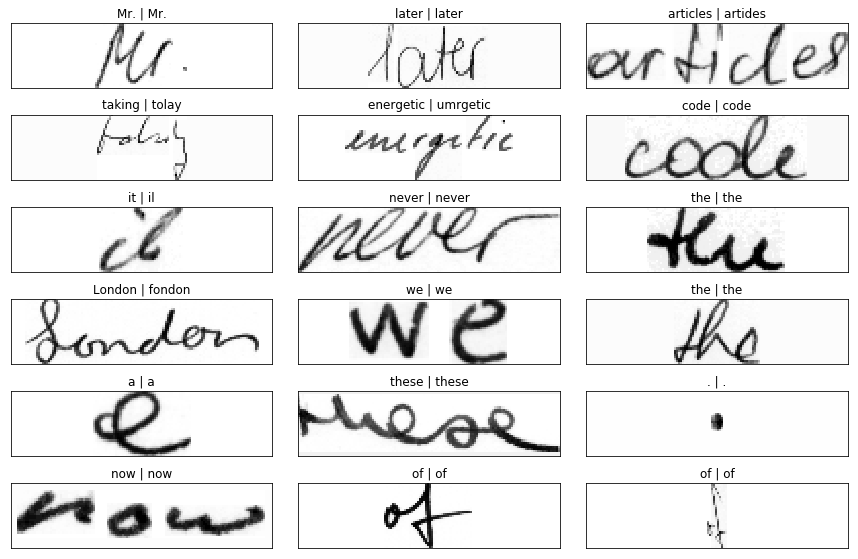

In [159]:
predictions = decode(output.softmax().topk(axis=2).asnumpy())
labels = decode(label.asnumpy())
plot_predictions(data, predictions, labels)

### Manual Testing

In [1]:
image_path = 'love.png'

In [ ]:
image = pre_processing(image_path).astype(np.float32)/255.
batchified_image = nd.array([np.expand_dims(image, axis=0)]*BATCH_SIZE, ctx)
output = net(batchified_image)
prediction = decode(output.softmax().topk(axis=2).asnumpy())

In [ ]:
plt.title(prediction[0])
plt.imshow(image, cmap='Greys_r')